In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from glob import glob

In [15]:
base_bone_dir = os.path.join('LilGrabbies')
age_df = pd.read_csv(os.path.join(base_bone_dir, 'LilGrabbies_training.csv'))
age_df['path'] = age_df['id'].map(lambda x: 'LilGrabbies/images/{}.png'.format(x))
age_df['exists'] = age_df['path'].map(os.path.exists)
test_df = age_df[age_df.alter.isnull()]
age_df = age_df[age_df.alter.notnull()]
age_df['m'] = age_df['geschlecht'].map(lambda x: 1 if x == 'm' else 0)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
boneage_mean = age_df['alter'].mean()
boneage_div = 2*age_df['alter'].std()
age_df['boneage_zscore'] = age_df['alter'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

10000 images found of 10000 total


,id,alter,geschlecht,path,exists,m,boneage_zscore
4224,14224,134.0,m,LilGrabbies/images/14224.png,True,1,0.081161
187,10187,162.0,m,LilGrabbies/images/10187.png,True,1,0.422293
9156,19156,100.0,w,LilGrabbies/images/19156.png,True,0,-0.333070


New Data Size: 8000 Old Size: 10000


array([[<AxesSubplot:title={'center':'alter'}>,
        <AxesSubplot:title={'center':'m'}>]], dtype=object)

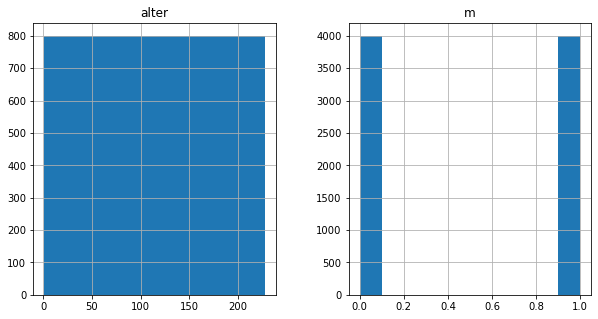

In [16]:
age_df['boneage_category'] = pd.cut(age_df['alter'], 10)
new_age_df = age_df.groupby(['boneage_category', 'm']).apply(lambda x: x.sample(400, replace = True)
                                                     ).reset_index(drop = True)
print('New Data Size:', new_age_df.shape[0], 'Old Size:', age_df.shape[0])
new_age_df[['alter', 'm']].hist(figsize = (10, 5))

array([[<AxesSubplot:title={'center':'alter'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'boneage_zscore'}>, <AxesSubplot:>]],
      dtype=object)

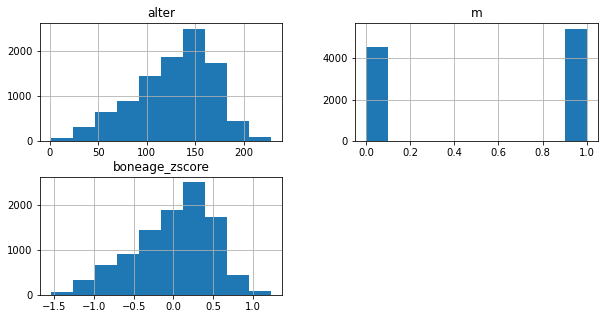

In [17]:
age_df[['alter', 'm', 'boneage_zscore']].hist(figsize = (10, 5))

In [18]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(new_age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 6000 validation 2000


In [23]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256,256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [24]:
train_gen = core_idg.flow_from_dataframe(train_df, 
                             x_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64, class_mode="raw")

valid_gen = core_idg.flow_from_dataframe(valid_df, 
                             x_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64, class_mode="raw")

test_X, test_Y = next(core_idg.flow_from_dataframe(
                               valid_df, 
                             x_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 500, class_mode="raw"))

Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


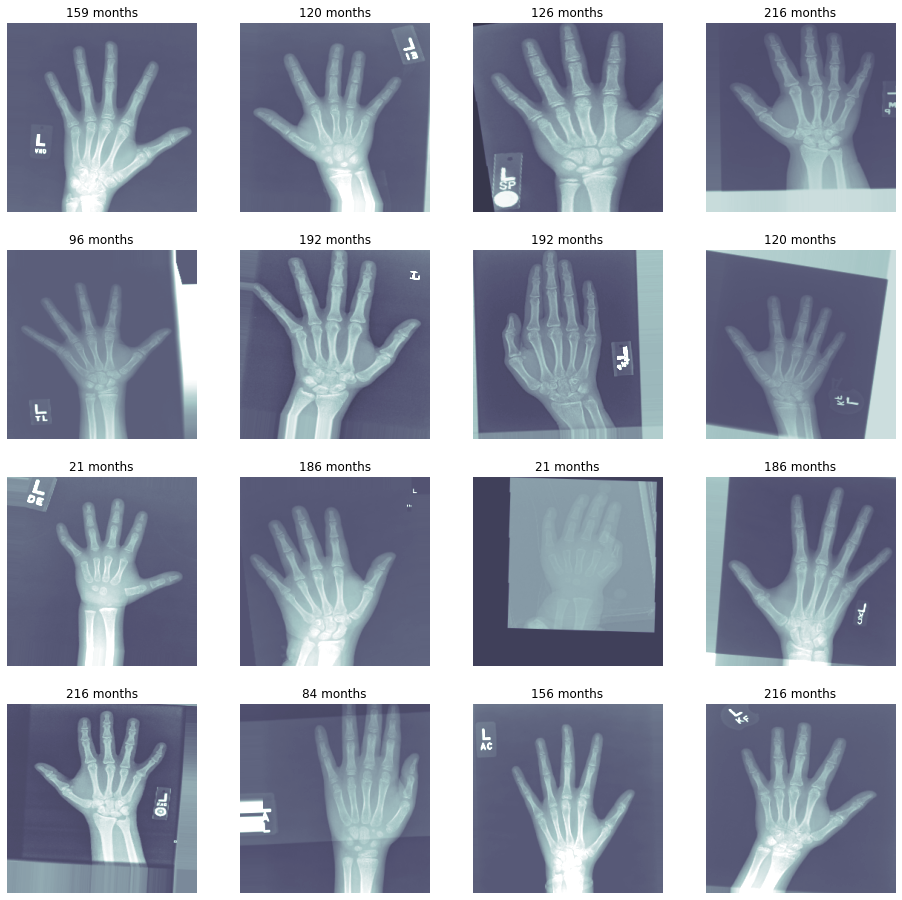

In [25]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -3, vmax = 3)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

In [28]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, 
                                 weights = None)
bone_age_model = Sequential()
bone_age_model.add(BatchNormalization(input_shape = t_x.shape[1:]))
bone_age_model.add(base_mobilenet_model)
bone_age_model.add(BatchNormalization())
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1, activation = 'linear' )) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 256, 256, 1)       4         
_________________________________________________________________
mobilenet_1.00_256 (Model)   (None, 8, 8, 1024)        3228288   
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_______________________________________

In [29]:

bone_age_model.load_weights(weight_path)


In [30]:

pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 16, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean


500/500 [==============================] - 52s 103ms/step


Text(0, 0.5, 'Predicted Age (Months)')

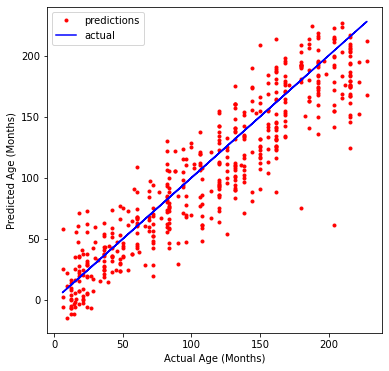

In [31]:

fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')


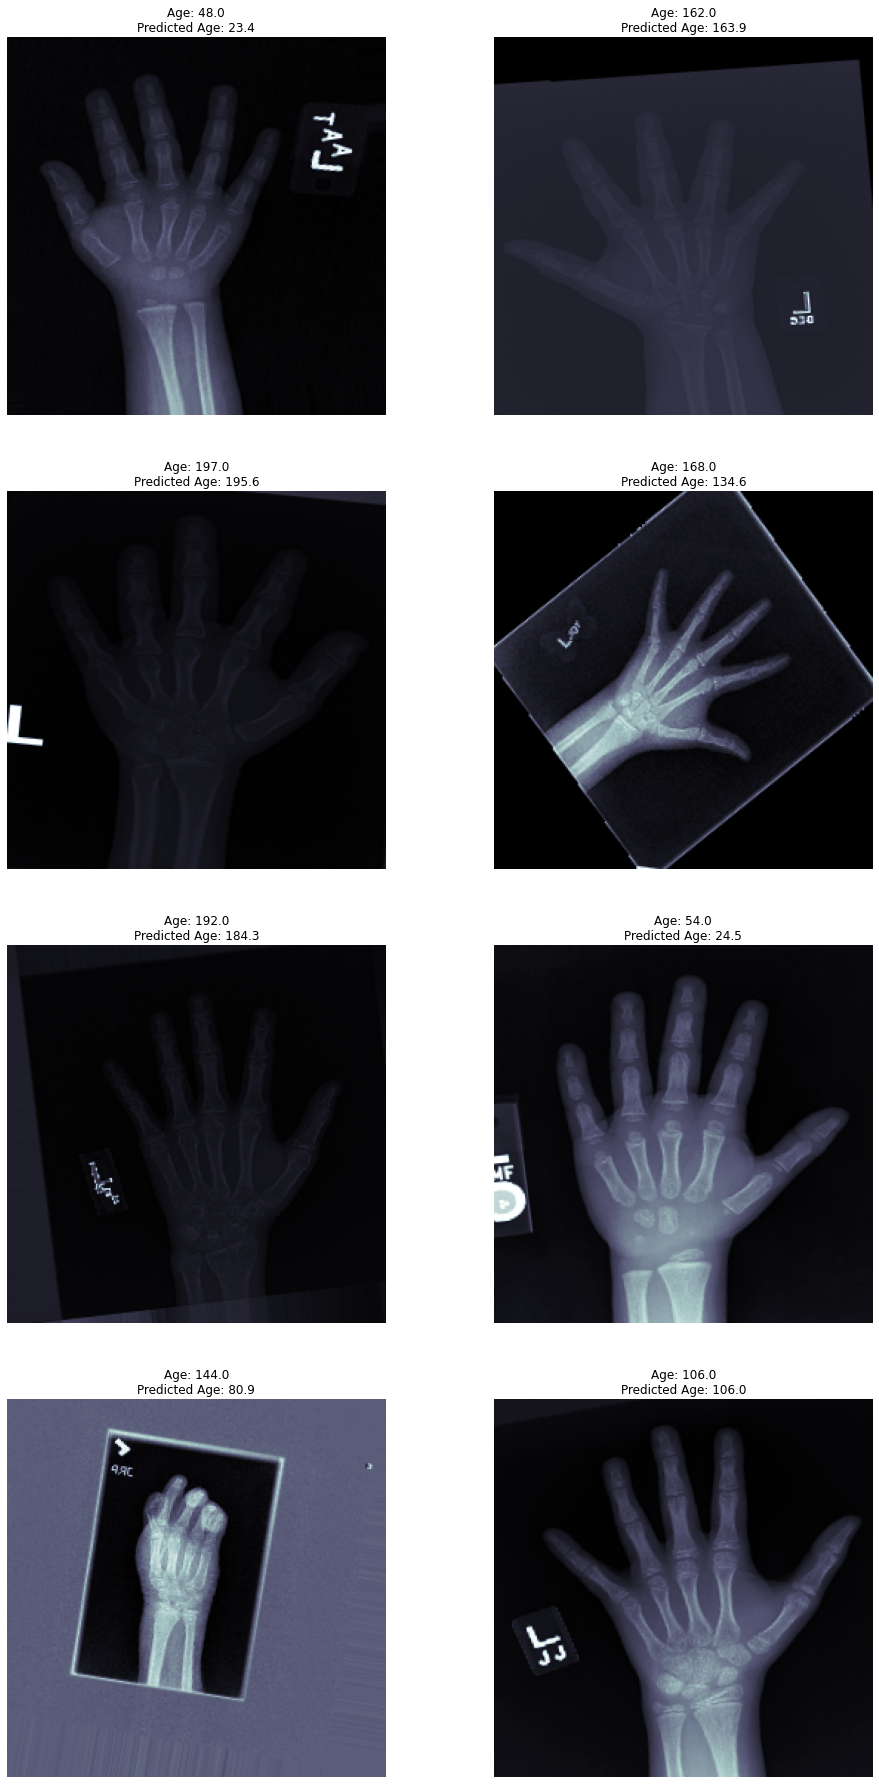

In [32]:

rand_idx = np.random.choice(range(test_X.shape[0]), 8)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(rand_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1f\nPredicted Age: %2.1f' % (test_Y_months[idx], pred_Y[idx]))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [48]:
idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True)



from tensorflow.keras.preprocessing.image import load_img,img_to_array

test_ims = []

for id in test_df["id"]:
    if id % 100 == 0:
        print("id = " + str(id))
    img = load_img("LilGrabbies/images/{}.png".format(id), color_mode="grayscale", target_size=IMG_SIZE)
    a = img_to_array(img)
    test_ims.append(a)

id = 20000
id = 20100
id = 20200
id = 20300
id = 20400
id = 20500
id = 20600
id = 20700
id = 20800
id = 20900
id = 21000
id = 21100
id = 21200
id = 21300
id = 21400
id = 21500
id = 21600
id = 21700
id = 21800
id = 21900
id = 22000
id = 22100
id = 22200
id = 22300
id = 22400


In [60]:
for i in range(len(test_ims)):
    x = (test_ims[i] - test_ims[i].mean()) / test_ims[i].std()
    test_ims[i] = x

In [61]:
test_im_array = np.array(test_ims)
test_Y = boneage_div*bone_age_model.predict(test_im_array, batch_size = 32, verbose = True)+boneage_mean

2500/2500 [==============================] - 294s 118ms/step


In [62]:
solution = pd.DataFrame({"id": test_df["id"], "alter": test_Y[:,0]})

In [64]:
with open("lilgrabbies2.txt", "w") as f:
    f.write("0a1a40ea65ef5445d80b569a47682e3d16077abd7960ab9f729fba15902672b3\n")
    f.write("lg-test3\n")
    f.write("\n".join([str(int(line[0])) + " " + str(int(line[1])) for line in solution.values]) + "\n")